Epoch 001, Loss: 0.6952, Train Acc: 0.5509
Epoch 002, Loss: 0.6895, Train Acc: 0.7109
Epoch 003, Loss: 0.6836, Train Acc: 0.8321
Epoch 004, Loss: 0.6773, Train Acc: 0.9075
Epoch 005, Loss: 0.6718, Train Acc: 0.9254
Epoch 006, Loss: 0.6654, Train Acc: 0.9406
Epoch 007, Loss: 0.6586, Train Acc: 0.9451
Epoch 008, Loss: 0.6515, Train Acc: 0.9475
Epoch 009, Loss: 0.6446, Train Acc: 0.9498
Epoch 010, Loss: 0.6363, Train Acc: 0.9515
Epoch 011, Loss: 0.6296, Train Acc: 0.9489
Epoch 012, Loss: 0.6201, Train Acc: 0.9493
Epoch 013, Loss: 0.6120, Train Acc: 0.9508
Epoch 014, Loss: 0.6037, Train Acc: 0.9522
Epoch 015, Loss: 0.5944, Train Acc: 0.9533
Epoch 016, Loss: 0.5852, Train Acc: 0.9527
Epoch 017, Loss: 0.5760, Train Acc: 0.9527
Epoch 018, Loss: 0.5677, Train Acc: 0.9534
Epoch 019, Loss: 0.5585, Train Acc: 0.9537
Epoch 020, Loss: 0.5492, Train Acc: 0.9536
Epoch 021, Loss: 0.5409, Train Acc: 0.9542
Epoch 022, Loss: 0.5318, Train Acc: 0.9542
Epoch 023, Loss: 0.5213, Train Acc: 0.9540
Epoch 024, 

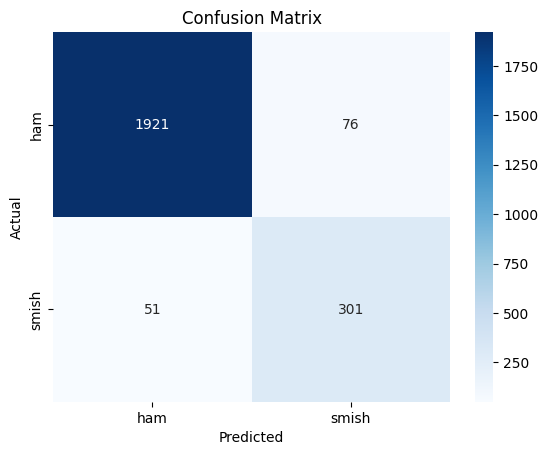

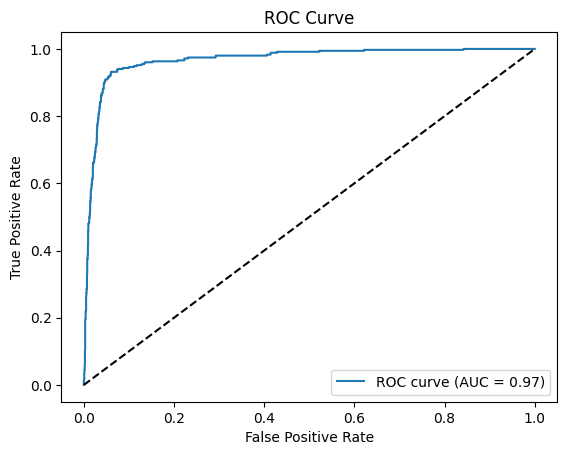

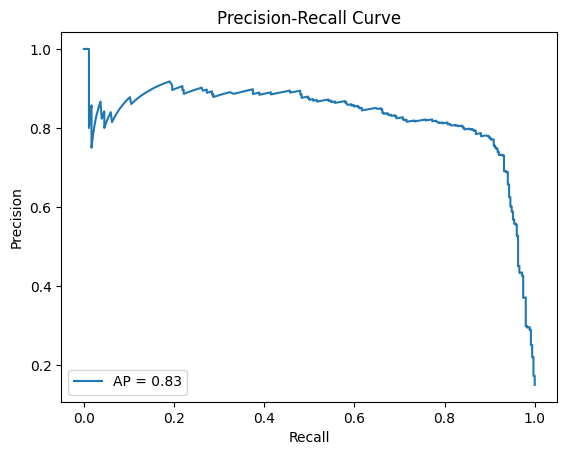

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HypergraphConv
from torch_geometric.data import Data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
import re
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load and preprocess dataset
# -----------------------------
df = pd.read_csv("Smishing_dataset1.csv")

# Text cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

df["message"] = df["Message"].apply(clean_text)

# Encode labels (ham=0, smish=1)
le = LabelEncoder()
df["label"] = le.fit_transform(df["Labels"])

# TF-IDF features
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["message"]).toarray()
y = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 2. Build Hypergraph Edges
# -----------------------------
def build_hypergraph(X, K=10):
    """
    Build hypergraph incidence matrix using KNN.
    Each node connected to its K nearest neighbors -> hyperedge.
    """
    N = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=K+1, metric="cosine").fit(X)
    _, indices = nbrs.kneighbors(X)

    edge_index = []
    for i in range(N):
        for j in indices[i]:
            edge_index.append([j, i])  # node j -> hyperedge i
    return torch.tensor(edge_index, dtype=torch.long).t()

edge_index_train = build_hypergraph(X_train, K=10)

x = torch.tensor(X_train, dtype=torch.float)
y_train_t = torch.tensor(y_train, dtype=torch.long)

data = Data(x=x, edge_index=edge_index_train, y=y_train_t)

# -----------------------------
# 3. Define HGNN Model
# -----------------------------
class HGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(HGNN, self).__init__()
        self.hconv1 = HypergraphConv(in_channels, hidden_channels)
        self.hconv2 = HypergraphConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.hconv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.hconv2(x, edge_index)
        return x

# -----------------------------
# 4. Training
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HGNN(in_channels=X_train.shape[1], hidden_channels=64, num_classes=2).to(device)

# Class weights for imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

data = data.to(device)

for epoch in range(1, 31):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    pred = out.argmax(dim=1)
    acc = (pred == data.y).sum().item() / data.y.size(0)
    print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Train Acc: {acc:.4f}")

# -----------------------------
# 5. Evaluation
# -----------------------------
edge_index_test = build_hypergraph(X_test, K=10)
data_test = Data(
    x=torch.tensor(X_test, dtype=torch.float),
    edge_index=edge_index_test,
    y=torch.tensor(y_test, dtype=torch.long)
).to(device)

model.eval()
with torch.no_grad():  # ensures no gradient tracking
    out_test = model(data_test.x, data_test.edge_index)
    probs_test = F.softmax(out_test, dim=1)[:, 1].cpu().numpy()
    pred_test = out_test.argmax(dim=1).cpu().numpy()
    true_test = data_test.y.cpu().numpy()


# Metrics
print("\nClassification Report:")
print(classification_report(true_test, pred_test, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(true_test, pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(true_test, probs_test)
roc_auc = roc_auc_score(true_test, probs_test)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_test, probs_test)
avg_precision = average_precision_score(true_test, probs_test)
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


Epoch 001 | Train Loss: 0.6962, Train Acc: 0.8414 | Val Loss: 0.6910, Val Acc: 0.8671
Epoch 002 | Train Loss: 0.6900, Train Acc: 0.8712 | Val Loss: 0.6866, Val Acc: 0.9199
Epoch 003 | Train Loss: 0.6841, Train Acc: 0.9069 | Val Loss: 0.6821, Val Acc: 0.9387
Epoch 004 | Train Loss: 0.6787, Train Acc: 0.9332 | Val Loss: 0.6774, Val Acc: 0.9432
Epoch 005 | Train Loss: 0.6726, Train Acc: 0.9432 | Val Loss: 0.6723, Val Acc: 0.9449
Epoch 006 | Train Loss: 0.6667, Train Acc: 0.9466 | Val Loss: 0.6668, Val Acc: 0.9466
Epoch 007 | Train Loss: 0.6592, Train Acc: 0.9487 | Val Loss: 0.6609, Val Acc: 0.9472
Epoch 008 | Train Loss: 0.6526, Train Acc: 0.9496 | Val Loss: 0.6547, Val Acc: 0.9478
Epoch 009 | Train Loss: 0.6453, Train Acc: 0.9498 | Val Loss: 0.6482, Val Acc: 0.9483
Epoch 010 | Train Loss: 0.6373, Train Acc: 0.9501 | Val Loss: 0.6414, Val Acc: 0.9483
Epoch 011 | Train Loss: 0.6297, Train Acc: 0.9498 | Val Loss: 0.6344, Val Acc: 0.9489
Epoch 012 | Train Loss: 0.6215, Train Acc: 0.9507 | Va

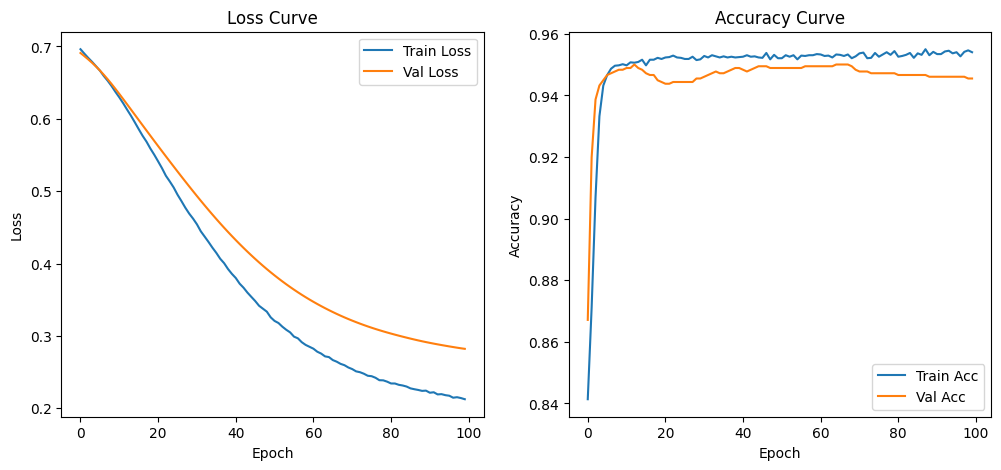


Final Test Metrics:
Accuracy:  0.9393
Precision: 0.7918
Recall:    0.8068
F1-score:  0.7992

Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.96      0.96      1498
       smish       0.79      0.81      0.80       264

    accuracy                           0.94      1762
   macro avg       0.88      0.88      0.88      1762
weighted avg       0.94      0.94      0.94      1762



In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HypergraphConv
from torch_geometric.data import Data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import re
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load and preprocess dataset
# -----------------------------
df = pd.read_csv("Smishing_dataset1.csv")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

df["message"] = df["Message"].apply(clean_text)

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["Labels"])

# TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["message"]).toarray()
y = df["label"].values

# Split -> train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# -----------------------------
# 2. Build Hypergraph Edges
# -----------------------------
def build_hypergraph(X, K=10):
    N = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=K+1, metric="cosine").fit(X)
    _, indices = nbrs.kneighbors(X)
    edge_index = []
    for i in range(N):
        for j in indices[i]:
            edge_index.append([j, i])  # node j -> hyperedge i
    return torch.tensor(edge_index, dtype=torch.long).t()

def make_data(X, y, K=10):
    edge_index = build_hypergraph(X, K)
    return Data(
        x=torch.tensor(X, dtype=torch.float),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.long)
    )

data_train = make_data(X_train, y_train, K=10)
data_val   = make_data(X_val, y_val, K=10)
data_test  = make_data(X_test, y_test, K=10)

# -----------------------------
# 3. HGNN Model
# -----------------------------
class HGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(HGNN, self).__init__()
        self.hconv1 = HypergraphConv(in_channels, hidden_channels)
        self.hconv2 = HypergraphConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.hconv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.hconv2(x, edge_index)
        return x

# -----------------------------
# 4. Training Loop (with validation)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HGNN(in_channels=X_train.shape[1], hidden_channels=64, num_classes=2).to(device)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

data_train, data_val, data_test = data_train.to(device), data_val.to(device), data_test.to(device)

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, 101):
    # ---- Training ----
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index)
    loss = criterion(out, data_train.y)
    loss.backward()
    optimizer.step()

    pred = out.argmax(dim=1)
    acc = (pred == data_train.y).sum().item() / data_train.y.size(0)

    # ---- Validation ----
    model.eval()
    with torch.no_grad():
        out_val = model(data_val.x, data_val.edge_index)
        val_loss = criterion(out_val, data_val.y).item()
        val_pred = out_val.argmax(dim=1)
        val_acc = (val_pred == data_val.y).sum().item() / data_val.y.size(0)

    train_losses.append(loss.item())
    val_losses.append(val_loss)
    train_accs.append(acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f}, Train Acc: {acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# -----------------------------
# 5. Plot Training vs Validation
# -----------------------------
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

# -----------------------------
# 6. Final Evaluation on Test Set
# -----------------------------
model.eval()
with torch.no_grad():
    out_test = model(data_test.x, data_test.edge_index)
    pred_test = out_test.argmax(dim=1).cpu().numpy()
    true_test = data_test.y.cpu().numpy()

# Metrics
acc = accuracy_score(true_test, pred_test)
prec = precision_score(true_test, pred_test)
rec = recall_score(true_test, pred_test)
f1 = f1_score(true_test, pred_test)

print("\nFinal Test Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(true_test, pred_test, target_names=le.classes_))


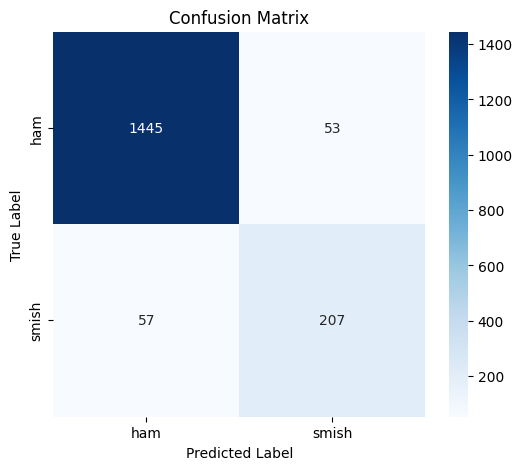


Classification Report:
              precision    recall  f1-score   support

         ham       0.96      0.96      0.96      1498
       smish       0.80      0.78      0.79       264

    accuracy                           0.94      1762
   macro avg       0.88      0.87      0.88      1762
weighted avg       0.94      0.94      0.94      1762



In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(true_test, pred_test)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report (already printed, but printing again for clarity)
print("\nClassification Report:")
print(classification_report(true_test, pred_test, target_names=le.classes_))


Epoch 001 | Train Loss: 0.6950, Train Acc: 0.5739 | Val Loss: 0.6901, Val Acc: 0.7941
Epoch 002 | Train Loss: 0.6891, Train Acc: 0.7688 | Val Loss: 0.6858, Val Acc: 0.8916
Epoch 003 | Train Loss: 0.6833, Train Acc: 0.8716 | Val Loss: 0.6814, Val Acc: 0.9150
Epoch 004 | Train Loss: 0.6778, Train Acc: 0.9121 | Val Loss: 0.6766, Val Acc: 0.9165
Epoch 005 | Train Loss: 0.6715, Train Acc: 0.9264 | Val Loss: 0.6714, Val Acc: 0.9172
Epoch 006 | Train Loss: 0.6648, Train Acc: 0.9262 | Val Loss: 0.6658, Val Acc: 0.9187
Epoch 007 | Train Loss: 0.6578, Train Acc: 0.9281 | Val Loss: 0.6598, Val Acc: 0.9172
Epoch 008 | Train Loss: 0.6510, Train Acc: 0.9308 | Val Loss: 0.6535, Val Acc: 0.9172
Epoch 009 | Train Loss: 0.6431, Train Acc: 0.9295 | Val Loss: 0.6469, Val Acc: 0.9165
Epoch 010 | Train Loss: 0.6352, Train Acc: 0.9306 | Val Loss: 0.6401, Val Acc: 0.9172
Epoch 011 | Train Loss: 0.6273, Train Acc: 0.9298 | Val Loss: 0.6331, Val Acc: 0.9179
Epoch 012 | Train Loss: 0.6187, Train Acc: 0.9295 | Va

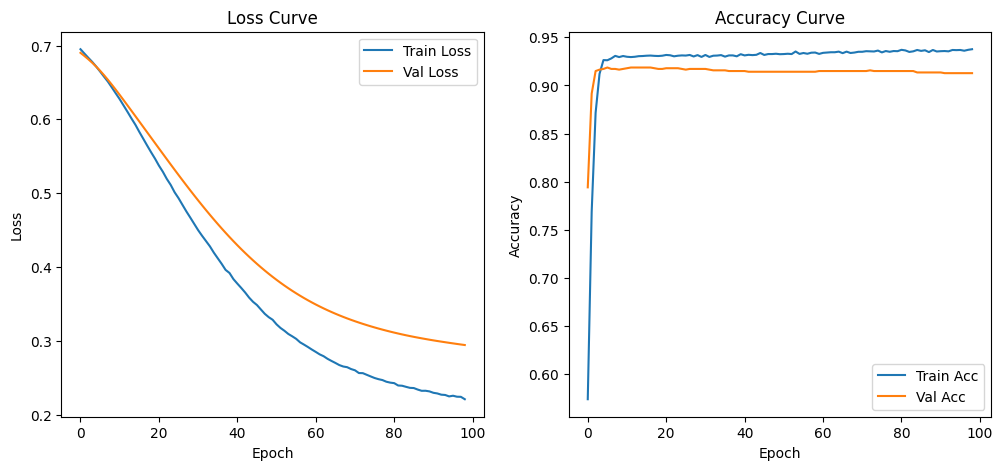


Final Test Metrics:
Accuracy:  0.9012
Precision: 0.9062
Recall:    0.8620
F1-score:  0.8835

Classification Report:
              precision    recall  f1-score   support

         ham       0.90      0.93      0.91       772
       smish       0.91      0.86      0.88       594

    accuracy                           0.90      1366
   macro avg       0.90      0.90      0.90      1366
weighted avg       0.90      0.90      0.90      1366



In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HypergraphConv
from torch_geometric.data import Data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import re
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load and preprocess dataset
# -----------------------------
df = pd.read_csv("Smishing_dataset.csv")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

df["message"] = df["Message"].apply(clean_text)

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["Labels"])

# TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["message"]).toarray()
y = df["label"].values

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# -----------------------------
# 2. Hypergraph Builder
# -----------------------------
def build_hypergraph(X, K=10):
    N = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=K+1, metric="cosine").fit(X)
    _, indices = nbrs.kneighbors(X)
    edge_index = []
    for i in range(N):
        for j in indices[i]:
            edge_index.append([j, i])  # node j -> hyperedge i
    return torch.tensor(edge_index, dtype=torch.long).t()

def make_data(X, y, K=10):
    edge_index = build_hypergraph(X, K)
    return Data(x=torch.tensor(X, dtype=torch.float),
                edge_index=edge_index,
                y=torch.tensor(y, dtype=torch.long))

data_train, data_val, data_test = make_data(X_train, y_train), make_data(X_val, y_val), make_data(X_test, y_test)

# -----------------------------
# 3. HGNN Model
# -----------------------------
class HGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(HGNN, self).__init__()
        self.hconv1 = HypergraphConv(in_channels, hidden_channels)
        self.hconv2 = HypergraphConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.hconv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.hconv2(x, edge_index)
        return x

# -----------------------------
# 4. Training with Early Stopping
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HGNN(in_channels=X_train.shape[1], hidden_channels=64, num_classes=2).to(device)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

data_train, data_val, data_test = data_train.to(device), data_val.to(device), data_test.to(device)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float("inf")
patience, patience_counter = 5, 0  # Early stopping patience
best_model_state = None

for epoch in range(1, 100):  # allow more epochs, early stopping will cut it short
    # ---- Training ----
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index)
    loss = criterion(out, data_train.y)
    loss.backward()
    optimizer.step()

    pred = out.argmax(dim=1)
    acc = (pred == data_train.y).sum().item() / data_train.y.size(0)

    # ---- Validation ----
    model.eval()
    with torch.no_grad():
        out_val = model(data_val.x, data_val.edge_index)
        val_loss = criterion(out_val, data_val.y).item()
        val_pred = out_val.argmax(dim=1)
        val_acc = (val_pred == data_val.y).sum().item() / data_val.y.size(0)

    train_losses.append(loss.item())
    val_losses.append(val_loss)
    train_accs.append(acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f}, Train Acc: {acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # ---- Early Stopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best model
model.load_state_dict(best_model_state)

# -----------------------------
# 5. Plot Learning Curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# -----------------------------
# 6. Final Evaluation on Test Set
# -----------------------------
model.eval()
with torch.no_grad():
    out_test = model(data_test.x, data_test.edge_index)
    pred_test = out_test.argmax(dim=1).cpu().numpy()
    true_test = data_test.y.cpu().numpy()

# Metrics
acc = accuracy_score(true_test, pred_test)
prec = precision_score(true_test, pred_test)
rec = recall_score(true_test, pred_test)
f1 = f1_score(true_test, pred_test)

print("\nFinal Test Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(true_test, pred_test, target_names=le.classes_))


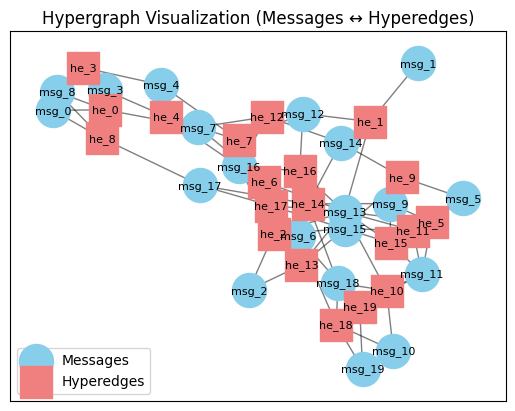


Message Mapping:
msg_0: i accidentally brought em home in the box...
msg_1: omg how did u know what i ate...
msg_2: happened here while you were adventuring...
msg_3: send me the new number...
msg_4:  ready then call me...
msg_5: hey come online use msn we are all there...
msg_6: i want to sent  ltgt mesages today thats y sorry if i hurts...
msg_7: i can call in  ltgt  min if thats ok...
msg_8: oh godtaken the teethis it paining...
msg_9: monthly password for wap mobsicom is 391784 use your wap pho...
msg_10: later i guess i needa do mcat study too...
msg_11: yeah imma come over cause jay wants to do some drugs...
msg_12: ello babe u ok...
msg_13: im parked next to a mini when are you coming in today do you...
msg_14: a cute thought for friendship its not necessary to share eve...
msg_15: jesus christ bitch im trying to give you drugs answer your f...
msg_16: oops sorry just to check that you dont mind picking me up to...
msg_17: reply with your name and address and you will receive b

In [3]:
import pandas as pd
import re
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# -----------------------------
# 1. Load + Clean Dataset
# -----------------------------
df = pd.read_csv("Smishing_dataset1.csv")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

df["message"] = df["Message"].apply(clean_text)

# Pick a small sample (20 messages for visualization)
sample_df = df.sample(20, random_state=42).reset_index(drop=True)

# -----------------------------
# 2. TF-IDF + Build Hypergraph
# -----------------------------
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(sample_df["message"]).toarray()

def build_hypergraph_edges(X, K=3):
    N = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=K+1, metric="cosine").fit(X)
    _, indices = nbrs.kneighbors(X)

    edges = []
    for i in range(N):
        for j in indices[i]:
            edges.append((f"msg_{j}", f"he_{i}"))  # msg = node, he = hyperedge
    return edges

edges = build_hypergraph_edges(X, K=3)

# -----------------------------
# 3. Build Graph in NetworkX
# -----------------------------
G = nx.Graph()
# Add message nodes (blue)
for i, msg in enumerate(sample_df["message"]):
    G.add_node(f"msg_{i}", label=f"msg_{i}", type="message", text=msg)

# Add hyperedge nodes (red)
for i in range(len(sample_df)):
    G.add_node(f"he_{i}", label=f"he_{i}", type="hyperedge")

# Add edges
G.add_edges_from(edges)

# -----------------------------
# 4. Draw Graph
# -----------------------------
pos = nx.spring_layout(G, seed=42)

# Draw nodes
msg_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "message"]
he_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "hyperedge"]

nx.draw_networkx_nodes(G, pos, nodelist=msg_nodes, node_color="skyblue", node_size=600, label="Messages")
nx.draw_networkx_nodes(G, pos, nodelist=he_nodes, node_color="lightcoral", node_shape="s", node_size=500, label="Hyperedges")

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Labels (just node names for clarity)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Hypergraph Visualization (Messages ↔ Hyperedges)")
plt.legend(scatterpoints=1)
plt.show()

# -----------------------------
# 5. Print Message Mapping
# -----------------------------
print("\nMessage Mapping:")
for i, msg in enumerate(sample_df["message"]):
    print(f"msg_{i}: {msg[:60]}...")


e:\Smish_detector\Cybertextshield\Cybertextshield_deployed\backend\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 001 | Train Loss: 0.6936, Train Acc: 0.6268 | Val Loss: 0.6871, Val Acc: 0.7547
Epoch 002 | Train Loss: 0.6870, Train Acc: 0.7515 | Val Loss: 0.6817, Val Acc: 0.8227
Epoch 003 | Train Loss: 0.6801, Train Acc: 0.8506 | Val Loss: 0.6762, Val Acc: 0.8801
Epoch 004 | Train Loss: 0.6734, Train Acc: 0.8977 | Val Loss: 0.6705, Val Acc: 0.8951
Epoch 005 | Train Loss: 0.6667, Train Acc: 0.9169 | Val Loss: 0.6645, Val Acc: 0.9051
Epoch 006 | Train Loss: 0.6593, Train Acc: 0.9247 | Val Loss: 0.6580, Val Acc: 0.9151
Epoch 007 | Train Loss: 0.6515, Train Acc: 0.9282 | Val Loss: 0.6513, Val Acc: 0.9182
Epoch 008 | Train Loss: 0.6436, Train Acc: 0.9320 | Val Loss: 0.6442, Val Acc: 0.9176
Epoch 009 | Train Loss: 0.6356, Train Acc: 0.9331 | Val Loss: 0.6368, Val Acc: 0.9176
Epoch 010 | Train Loss: 0.6266, Train Acc: 0.9337 | Val Loss: 0.6291, Val Acc: 0.9170
Epoch 011 | Train Loss: 0.6175, Train Acc: 0.9315 | Val Loss: 0.6212, Val Acc: 0.9170
Epoch 012 | Train Loss: 0.6084, Train Acc: 0.9325 | Va

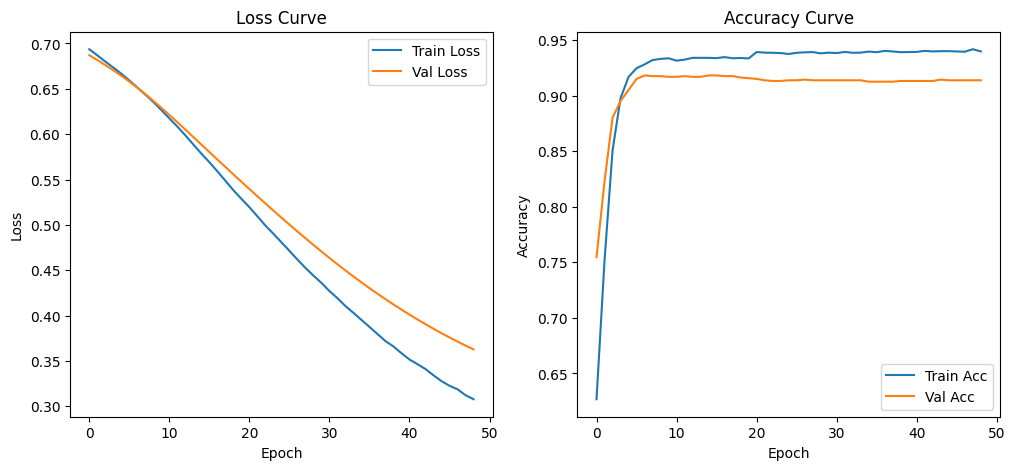


Final Test Metrics:
Accuracy:  0.9127
Precision: 0.8908
Recall:    0.8760
F1-score:  0.8833

Classification Report:
              precision    recall  f1-score   support

         ham       0.93      0.93      0.93       998
       smish       0.89      0.88      0.88       605

    accuracy                           0.91      1603
   macro avg       0.91      0.91      0.91      1603
weighted avg       0.91      0.91      0.91      1603



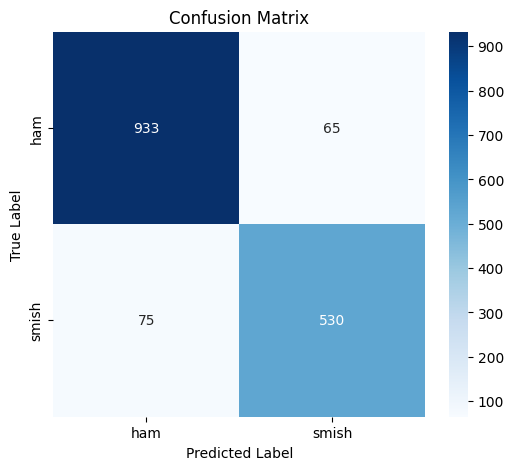

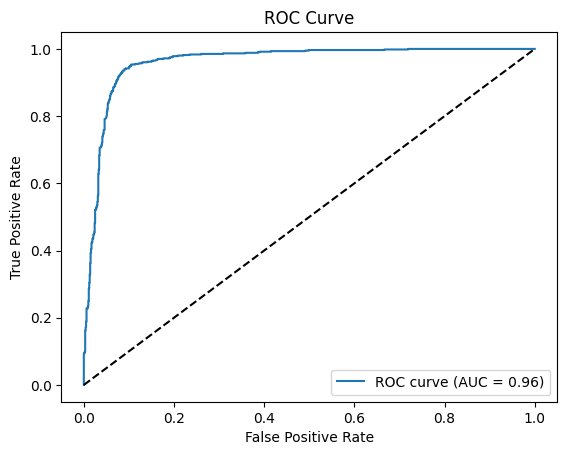

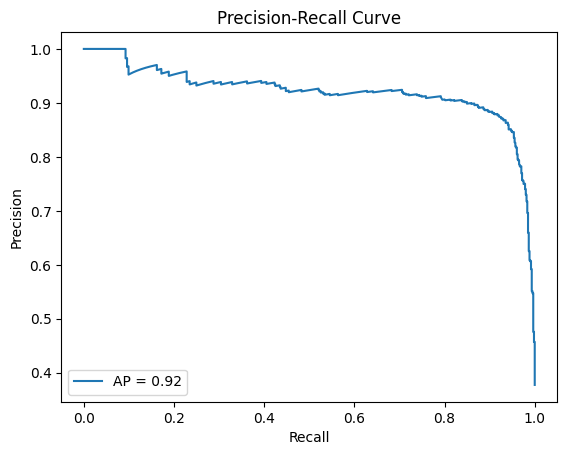


Model and preprocessing files saved: hgnn_smish_model.pth, tfidf_vectorizer.pkl, label_encoder.pkl


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HypergraphConv
from torch_geometric.data import Data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # for saving preprocessing objects

# -----------------------------
# 1. Load and preprocess dataset
# -----------------------------
df = pd.read_csv("Smishing_dataset copy.csv")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

df["message"] = df["Message"].apply(clean_text)

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["Labels"])

# TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["message"]).toarray()
y = df["label"].values

# Split -> train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# -----------------------------
# 2. Build Hypergraph Edges
# -----------------------------
def build_hypergraph(X, K=10):
    N = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=K+1, metric="cosine").fit(X)
    _, indices = nbrs.kneighbors(X)
    edge_index = []
    for i in range(N):
        for j in indices[i]:
            edge_index.append([j, i])  # node j -> hyperedge i
    return torch.tensor(edge_index, dtype=torch.long).t()

def make_data(X, y, K=10):
    edge_index = build_hypergraph(X, K)
    return Data(
        x=torch.tensor(X, dtype=torch.float),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.long)
    )

data_train = make_data(X_train, y_train, K=10)
data_val   = make_data(X_val, y_val, K=10)
data_test  = make_data(X_test, y_test, K=10)

# -----------------------------
# 3. HGNN Model
# -----------------------------
class HGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(HGNN, self).__init__()
        self.hconv1 = HypergraphConv(in_channels, hidden_channels)
        self.hconv2 = HypergraphConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.hconv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.hconv2(x, edge_index)
        return x

# -----------------------------
# 4. Training Loop (with validation)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HGNN(in_channels=X_train.shape[1], hidden_channels=64, num_classes=2).to(device)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

data_train, data_val, data_test = data_train.to(device), data_val.to(device), data_test.to(device)

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, 50):
    # ---- Training ----
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index)
    loss = criterion(out, data_train.y)
    loss.backward()
    optimizer.step()

    pred = out.argmax(dim=1)
    acc = (pred == data_train.y).sum().item() / data_train.y.size(0)

    # ---- Validation ----
    model.eval()
    with torch.no_grad():
        out_val = model(data_val.x, data_val.edge_index)
        val_loss = criterion(out_val, data_val.y).item()
        val_pred = out_val.argmax(dim=1)
        val_acc = (val_pred == data_val.y).sum().item() / data_val.y.size(0)

    train_losses.append(loss.item())
    val_losses.append(val_loss)
    train_accs.append(acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f}, Train Acc: {acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# -----------------------------
# 5. Plot Training vs Validation
# -----------------------------
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

# -----------------------------
# 6. Final Evaluation on Test Set
# -----------------------------
model.eval()
with torch.no_grad():
    out_test = model(data_test.x, data_test.edge_index)
    probs_test = F.softmax(out_test, dim=1)[:, 1].cpu().numpy()
    pred_test = out_test.argmax(dim=1).cpu().numpy()
    true_test = data_test.y.cpu().numpy()

# Metrics
acc = accuracy_score(true_test, pred_test)
prec = precision_score(true_test, pred_test)
rec = recall_score(true_test, pred_test)
f1 = f1_score(true_test, pred_test)

print("\nFinal Test Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(true_test, pred_test, target_names=le.classes_))

# -----------------------------
# 7. Confusion Matrix
# -----------------------------
cm = confusion_matrix(true_test, pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# 8. ROC Curve
# -----------------------------
fpr, tpr, _ = roc_curve(true_test, probs_test)
roc_auc = roc_auc_score(true_test, probs_test)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 9. Precision-Recall Curve
# -----------------------------
precision, recall, _ = precision_recall_curve(true_test, probs_test)
avg_precision = average_precision_score(true_test, probs_test)
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

# -----------------------------
# 10. Save Model and Preprocessing Files
# -----------------------------
torch.save(model.state_dict(), "hgnn_smish_model.pth")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")

print("\nModel and preprocessing files saved: hgnn_smish_model.pth, tfidf_vectorizer.pkl, label_encoder.pkl")


In [2]:
df = pd.read_csv("Smishing_dataset copy.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10603 entries, 0 to 10602
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Labels   10603 non-null  object
 1   Message  10603 non-null  object
dtypes: object(2)
memory usage: 165.8+ KB


In [3]:
df["Labels"].value_counts()

Labels
ham      6647
smish    3956
Name: count, dtype: int64


HGNN Performance:
{'Accuracy': 0.9182903834066625, 'Precision': 0.8766233766233766, 'Recall': 0.9090909090909091, 'F1-score': 0.8925619834710744}

Training Naive Bayes...

Naive Bayes Results:
{'Accuracy': 0.9495520980669495, 'Precision': 0.9150485436893204, 'Recall': 0.9532237673830595, 'F1-score': 0.9337461300309597}

Training Random Forest...

Random Forest Results:
{'Accuracy': 0.9448373408769448, 'Precision': 0.9129901960784313, 'Recall': 0.9418457648546145, 'F1-score': 0.9271935283136279}

Training KNN...

KNN Results:
{'Accuracy': 0.9566242338519566, 'Precision': 0.9106933019976499, 'Recall': 0.9797724399494311, 'F1-score': 0.9439707673568819}

Training SVM...

SVM Results:
{'Accuracy': 0.9533239038189534, 'Precision': 0.909952606635071, 'Recall': 0.9709228824273072, 'F1-score': 0.9394495412844037}

Final Model Comparison:

               Accuracy  Precision    Recall  F1-score
Naive Bayes    0.949552   0.915049  0.953224  0.933746
Random Forest  0.944837   0.912990  0.941846  

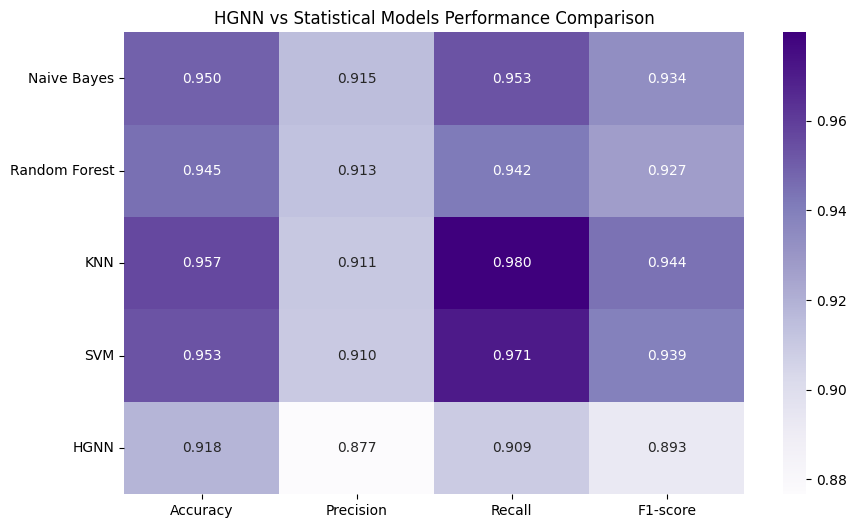

In [7]:
# ---- HGNN Predictions ----
hgnn_probs = probs_test
hgnn_pred = pred_test
hgnn_true = true_test

hgnn_metrics = {
    "Accuracy": accuracy_score(hgnn_true, hgnn_pred),
    "Precision": precision_score(hgnn_true, hgnn_pred),
    "Recall": recall_score(hgnn_true, hgnn_pred),
    "F1-score": f1_score(hgnn_true, hgnn_pred)
}

print("\nHGNN Performance:")
print(hgnn_metrics)

# Reuse vectorizer from HGNN
X_full = vectorizer.transform(df["Message"]).toarray()
y_full = df["Labels"].values

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

ml_models = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel="linear", probability=True)
}

results = {}

for name, model in ml_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_ml, y_train_ml)

    pred = model.predict(X_test_ml)

    results[name] = {
        "Accuracy": accuracy_score(y_test_ml, pred),
        "Precision": precision_score(y_test_ml, pred, pos_label="smish"),
        "Recall": recall_score(y_test_ml, pred, pos_label="smish"),
        "F1-score": f1_score(y_test_ml, pred, pos_label="smish")
    }

    print(f"\n{name} Results:")
    print(results[name])


results["HGNN"] = hgnn_metrics

comparison_df = pd.DataFrame(results).T
print("\nFinal Model Comparison:\n")
print(comparison_df)

plt.figure(figsize=(10,6))
sns.heatmap(comparison_df, annot=True, cmap="Purples", fmt=".3f")
plt.title("HGNN vs Statistical Models Performance Comparison")
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2400\572907068.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_values.index, y=accuracy_values.values, palette=colors)


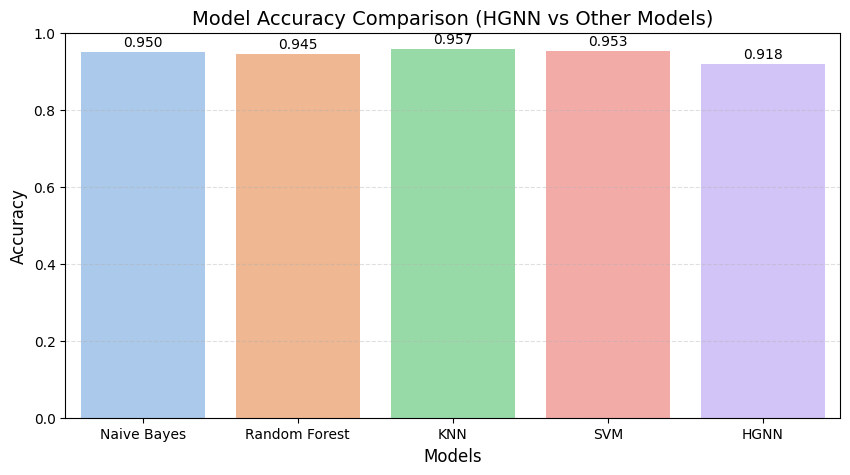

In [8]:
# =============== BAR GRAPH: ACCURACY COMPARISON ===============

plt.figure(figsize=(10, 5))

# Extract accuracy values from comparison table
accuracy_values = comparison_df["Accuracy"]

# Color palette
colors = sns.color_palette("pastel", len(accuracy_values))

# Bar plot
sns.barplot(x=accuracy_values.index, y=accuracy_values.values, palette=colors)

plt.title("Model Accuracy Comparison (HGNN vs Other Models)", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)  # since accuracy ranges from 0–1
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add value labels
for i, v in enumerate(accuracy_values.values):
    plt.text(i, v + 0.015, f"{v:.3f}", ha='center', fontsize=10)

plt.show()
